In [1]:
import os
import glob
from BF_main import read_data_and_configs, run_beamformer, run_image_processing, pre_process_configs, precompute_geometry
from beamformer_calc_rtbf import recon_field_apod
from PIL import Image
import numpy as np
#%matplotlib inline
%matplotlib notebook
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
import time

start_time = time.time()
challenge_set = ['L7-4_General']

dir = challenge_set[0]

data_dir = f'Challenge_sets/{dir}'
config_dir = os.path.join(data_dir, 'presets/scratch')
raw_rf_dir = os.path.join(data_dir, 'data')
raw_rf_files = glob.glob(os.path.join(raw_rf_dir, '*_raw_rf.npy'))
cine_files = glob.glob(os.path.join(raw_rf_dir, '*_cine.npy'))
image_files = glob.glob(os.path.join(raw_rf_dir, '*.png'))
#use first file
#raw_rf_path = os.path.join(raw_rf_dir, Files[0])
mode = 0
rf_data, preset = read_data_and_configs(raw_rf_dir, config_dir, mode)
print('time to read data and configs {}'.format(time.time()-start_time))
xdc, field, param = pre_process_configs(preset,mode)
print('time to preprocess configs {}'.format(time.time()-start_time))
recon = precompute_geometry(xdc, field, param)
print('time to precompute geometry {}'.format(time.time()-start_time))
print('done')

grabbing data and config
loading preset Challenge_sets/L7-4_General\presets/scratch
time to read data and configs 27.92492175102234
time to preprocess configs 27.925921201705933
precomputing geometry...
precomputing field...
pre computing delays, limiters, and apodization...


C:\code\signal_processing_dev\dstMain_reference_model\beamformer.py:156: RuntimeWarning: divide by zero encountered in divide
  tx_f_num = 0.5 * (f_num_pad + np.abs(recon['pv_z'])) / recon['pv_xy']
C:\code\signal_processing_dev\dstMain_reference_model\beamformer.py:163: RuntimeWarning: divide by zero encountered in divide
  rx_f_num = 0.5 * (f_num_pad + np.abs(recon['pr_z'])) / recon['pr_xy']


precompute took 28.68893720000051 seconds 
time to precompute geometry 56.632208824157715
done


In [4]:
print(recon["px_grid_Vec"].shape)
c_inv = 1/field["c"]

(128, 2597, 3)


In [5]:
# calculate vectors from virtual point source to pixel locations
recon["px_grid_Vec"].shape
# reshape vps for broadcast
vps_for_broadcast = recon["vps_grid_Vec"].reshape(-1,1,1,3)
# add vps axis for broadcast and subtract
pixel_to_vps_vec = recon["px_grid_Vec"][np.newaxis,:,:,:] - vps_for_broadcast
print(pixel_to_vps_vec.shape)

(128, 128, 2597, 3)


In [6]:
# calculate vectors from channels source to pixel locations
print(recon["px_grid_Vec"].shape)
# reshape xdc for broadcast
xdc_for_broadcast = recon["rcv_xdc_grid_Vec"].reshape(-1,1,1,3)
# add vps axis for broadcast and subtract
px_grid_vec_for_broadcast = recon["px_grid_Vec"][np.newaxis,:,:,:]
pixel_to_xdc_vec = px_grid_vec_for_broadcast - xdc_for_broadcast

(128, 2597, 3)


In [7]:
# calculate delay from beam center to VPS
T_vps = xdc["xmit_focus"] * c_inv + param["tx_delay"] 

(128, 128, 2597)


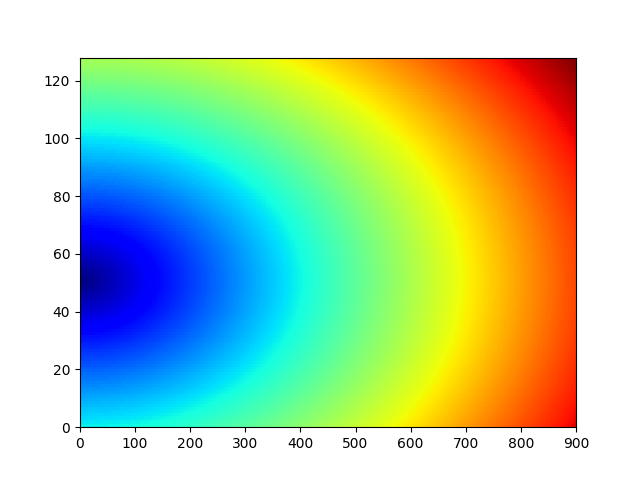

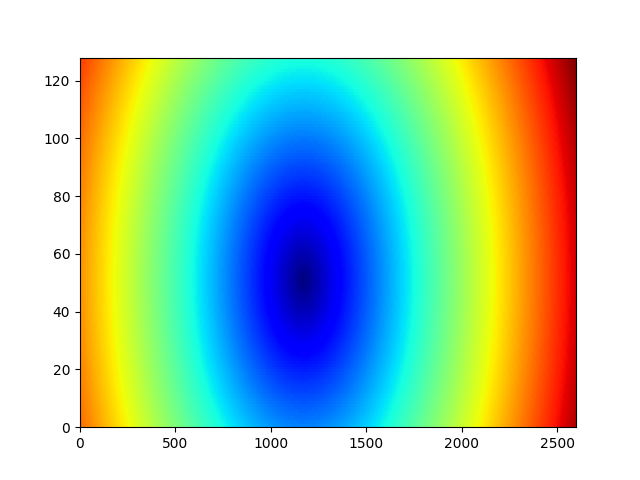

In [8]:
# calculate delays (s)
pixel_to_xdc_tof = np.linalg.norm(pixel_to_xdc_vec,axis=3)*c_inv
pixel_to_vps_tof = np.linalg.norm(pixel_to_vps_vec,axis=3)*c_inv
print(pixel_to_xdc_tof.shape)

fig, ax = plt.subplots()
ax.pcolormesh(pixel_to_xdc_tof[50,:,:900], cmap='jet')

fig, ax = plt.subplots()
ax.pcolormesh(pixel_to_vps_tof[50,:,:], cmap='jet')



In [9]:
# calculate TX limiter inputs

f_num_pad= 1/(c_inv*param["recon_cf"]) 

pv_z = (pixel_to_vps_vec[:,:,:,0])
pv_xy_vec = pixel_to_vps_vec[:,:,:,[1,2]]
pv_xy = np.linalg.norm(pv_xy_vec, axis=3)

#print(param["recon_cf"])
#print(1/c_inv)
#print((pv_xy_vec[0:10,0:10,3,:]))
#print((pv_z))
print(pv_z.shape)

(128, 128, 2597)


In [10]:
# calculate TX limiter
tx_f_num = 0.5*(f_num_pad + np.abs(pv_z))/pv_xy
recon["tx_limiter"] = np.where(tx_f_num >= param["recon_tx_fnum"],1,0)

C:\Users\timhm\AppData\Local\Temp\ipykernel_31264\4037398071.py:2: RuntimeWarning: divide by zero encountered in divide
  tx_f_num = 0.5*(f_num_pad + np.abs(pv_z))/pv_xy


In [11]:
# calculate RX limiter inputs
c_inv = 1/field["c"]
f_num_pad= 1/(c_inv*param["recon_cf"]) 

pr_z = np.abs(pixel_to_xdc_vec[:,:,:,0])

pr_xy_vec = pixel_to_xdc_vec[:,:,:,[1,2]]
pr_xy = np.linalg.norm(pr_xy_vec, axis=3)

In [12]:
# calculate RX limiter
rx_f_num = 0.5*(f_num_pad + np.abs(pr_z))/pr_xy
recon["rcv_limiter"] = np.where(rx_f_num >= param["recon_rx_fnum"],1,0)

C:\Users\timhm\AppData\Local\Temp\ipykernel_31264\2124589709.py:2: RuntimeWarning: divide by zero encountered in divide
  rx_f_num = 0.5*(f_num_pad + np.abs(pr_z))/pr_xy


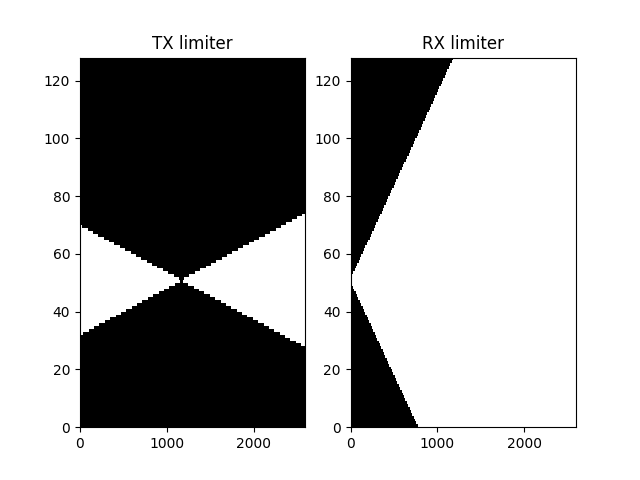

In [13]:
# plot tx_limiter

import matplotlib.pyplot as plt
import ipywidgets as widgets
fig, ax = plt.subplots(1,2)
ax[0].pcolormesh(recon["tx_limiter"][50,:,:], cmap = 'grey')
ax[0].set_title('TX limiter')

#plot_rx_limiter
ax[1].pcolormesh(recon["rcv_limiter"][50,:,:], cmap = 'grey')
ax[1].set_title('RX limiter')

plt.show()

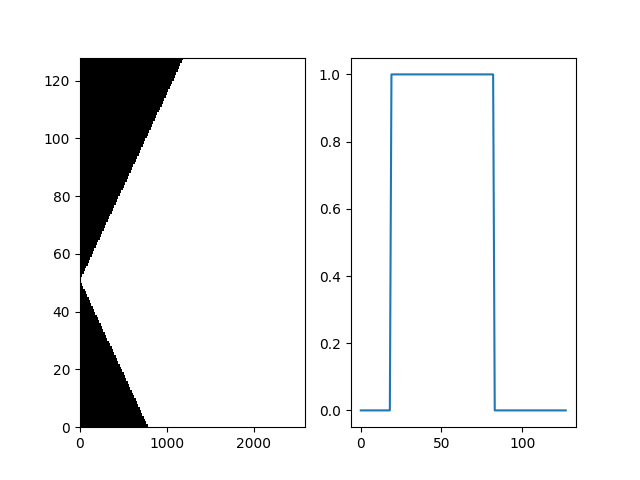

In [14]:
recon["apod_window"] = np.zeros(recon["rcv_limiter"].shape)
recon["window_num"] = 0

def ComputeUnscaledWindowWeight(x, x_range):
    if x_range == 0:
        return 0
    xx = x/x_range + 0.5
    if xx < 0 or xx > 1:
        return 0
    return 1

vectorized_window_weight = np.vectorize(ComputeUnscaledWindowWeight)

recon['apod'] = vectorized_window_weight(pr_xy*param["recon_rx_fnum"], pr_z)
fig, ax = plt.subplots(1,2)
ax[0].pcolormesh(recon['apod'][50,:,:], cmap = 'grey')
ax[1].plot(recon['apod'][50,:,500])

plt.show()

In [15]:
# perform delay and sum
tx_width_mm = float(param["recon_tx_width_wavelength"] * param['recon_wavelength'])
print(tx_width_mm)
print(xdc["pitch"])
tx_width = tx_width_mm/xdc["pitch"]
print(tx_width)
rtbf_range = np.arange(-int(param["recon_tx_width_wavelength"]/2),int(param["recon_tx_width_wavelength"]/2)+1)
print(rtbf_range)

0.004928
0.0002980000078678131
16.536912315069344
[-8 -7 -6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6  7  8]


In [16]:
print(rf_data.shape)

(128, 4066, 128)


127


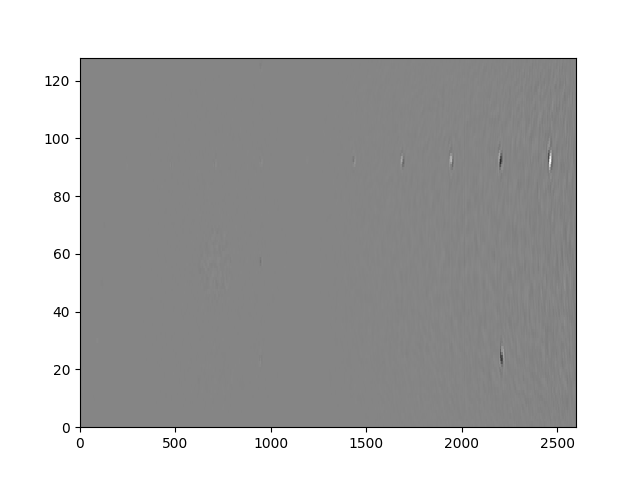

In [17]:
plt.close('all')
from IPython.display import display, clear_output
recon_image = np.zeros(recon["px_grid_Vec"][:,:,0].shape)
print(recon_image.shape)
print(pixel_to_vps_tof.shape)
channels = list(range(field['channels']))
#channels = [50]
#rtbf_range = np.array([0])
for channel in channels:
    clear_output(wait=True)
    print(channel)
    tx_range = [int(i) for i in rtbf_range+channel if i >=0 and i < 128]
    # get RX_delays
    rx_delays = np.copysign(pixel_to_xdc_tof[channel,:,:],
                            pr_z[channel,:,:])
    eligible_rx_pixels = np.where(recon["rcv_limiter"][channel,:,:])
    for tx_ind in tx_range:
        eligible_tx_pixels = np.where(recon["tx_limiter"][tx_ind,channel,:])
        tx_delays = np.zeros(recon_image.shape[1])
        tx_delays = np.copysign(pixel_to_vps_tof[tx_ind,channel,:],
                                pv_z[tx_ind,channel,:])
        tx_delays = tx_delays[np.newaxis,:]
                                                    
        # total delays for each pixel
        total_delay = T_vps + rx_delays + tx_delays
        samples = (total_delay * field['fs']).astype('int')
        # data lookup
        rf_data_lookup = np.zeros(samples.shape)
        for channel_ind in range(field['channels']):
            valid_samples = np.where(samples[channel_ind,:]<rf_data.shape[1])
            rf_data_lookup[channel_ind,valid_samples] = rf_data[channel_ind,samples[channel_ind,valid_samples], tx_ind]

        #print(rf_data_lookup.shape)
        rf_data_lookup = rf_data_lookup * recon['apod'][channel,:,:]
        #print(recon['apod'][channel,:,:].shape)
        eligible_pixels = np.where(recon["rcv_limiter"][channel,:,:] & recon["tx_limiter"][tx_ind,channel,:][np.newaxis,:])
        #eligble_pixels = np.where(recon["rcv_limiter"][channel,:,:])
        # zero out ineligible pixels
        rf_data_for_sum = np.zeros(rf_data_lookup.shape)
        rf_data_for_sum[eligible_pixels] = rf_data_lookup[eligible_pixels]
        #rf_data_for_sum[eligible_pixels] = samples[eligible_pixels]
        #rf_data_for_sum = rx_delays
        #rf_data_for_sum[eligible_pixels] = 1
        if tx_ind == channel+1 and False:
            fig, ax_tx_delay = plt.subplots()
            print(tx_delays)
            ax_tx_delay.plot(tx_delays[0,:])
            #ax_tx_delay.plot(pv_z[tx_ind,channel,:])

            fig, ax = plt.subplots(2,1)
            ax[0].pcolormesh(rx_delays[:,:985])
            ax[0].set_title('rx_delays')
            print(pixel_to_xdc_tof.shape)
            #c = ax.pcolormesh(pixel_to_xdc_tof[channel,:,:600])
            
            c = ax[1].pcolormesh(tx_delays[:,:])
            ax[1].set_title('tx_delays')
            fig.colorbar(c, ax=ax)
            plt.show()
        summed_data = np.sum(rf_data_for_sum,axis=0)
        recon_image[channel,:] += np.sum(rf_data_for_sum,axis=0)

rotation = Affine2D().rotate_deg(-90)
fig, ax = plt.subplots()
ax.pcolormesh(recon_image, cmap = 'grey')


In [18]:
print('total time {}'.format(time.time()-start_time))

total time 623.4116351604462


(128, 2597)
Challenge_sets/L7-4_General\data\L7-4_General_screenshot_0.png
getting envelope
plotting for display


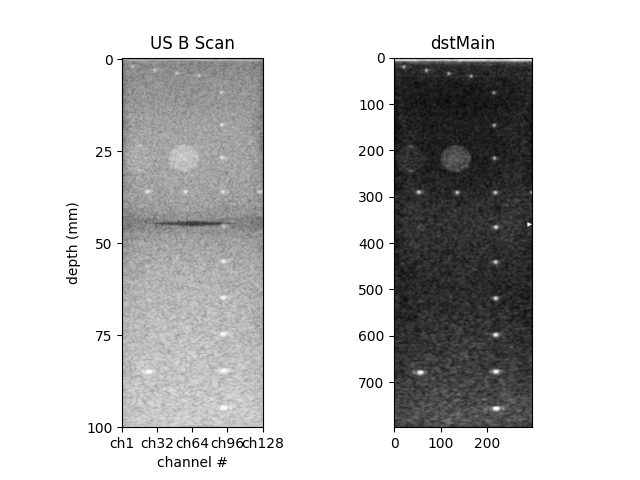

In [19]:
num_samples = rf_data.shape[1]
title = raw_rf_files[0].split('\\')[-1].split('.')[0]
fig, ax = plt.subplots(1,2)
print(recon_image.shape)

image = Image.open(image_files[0])
print(image_files[0])
image_array = np.array(image)
if xdc['type'] == 0:
    image_array = image_array[41:839, 442:740, :]  # grab image from display
else:
    image_array = image_array[183:700, 230:950, :] #curvilinear image splice
ax[1].imshow(image_array)
ax[1].set_title('dstMain')

recon_image = recon_image / 2 ** 15
run_image_processing(recon_image, xdc, field, param, num_samples, title = title, ax=ax[0])